
# 分仓散点图

## 何谓分仓散点图

分仓散点图（也称为分组均值图、Binned Scatterplot、Grouped Scatterplot），是将连续自变量 $x$ 按照某种规则分为若干组（bin/decile/quantile），每组内取 $x$ 和 $y$ 的均值，进而绘制 $(\bar{x}_g, \bar{y}_g)$ 散点。

这种方法可以有效缓解单个观测值的随机波动与噪音影响，更直观地展示 $x$ 与 $y$ 的整体关系和非线性结构。分仓散点图常用于大样本、点密集的数据集，是经济学、社会科学等领域中描述性和机制检验的重要可视化工具。

## binscatter 的绘制具体步骤

1. **选择分组变量**：通常为 $x$。
2. **确定分组方式与分组数 $G$**：
   * 通常用分位数（如十分位）、也可等宽分组 (每组的样本数相同)；
   * $G$ 一般取 10-20，样本量大时可适当增加。
3. **组内计算均值**：每组算出 $\bar{x}_g, \bar{y}_g$ 或 $\bar{\tilde{x}}_g, \bar{\tilde{y}}_g$。其中，$g = 1, 2, \cdots G$
4. **绘图**：以 $(\bar{x}_g, \bar{y}_g)$ 绘制散点；可叠加拟合线 (基于原始数据而非生成的散点)、置信区间等。



模拟如下过程：
1. y = 10 + 0.5x + e
2. e ~ N(0, 1)
3. x ~ N(5, 2)
4. 样本量为 500
5. 绘制分仓散点图，bins = 10，每组的样本数相同；添加分仓线 (虚线，灰色)
6. 添加：原始数据的拟合线 (实线，蓝色)，置信区间 (阴影区域，蓝色，透明度=0.3)。
7. 添加：分仓散点图的拟合线 (实线，红色)，置信区间 (阴影区域，红色，透明度=0.3)。

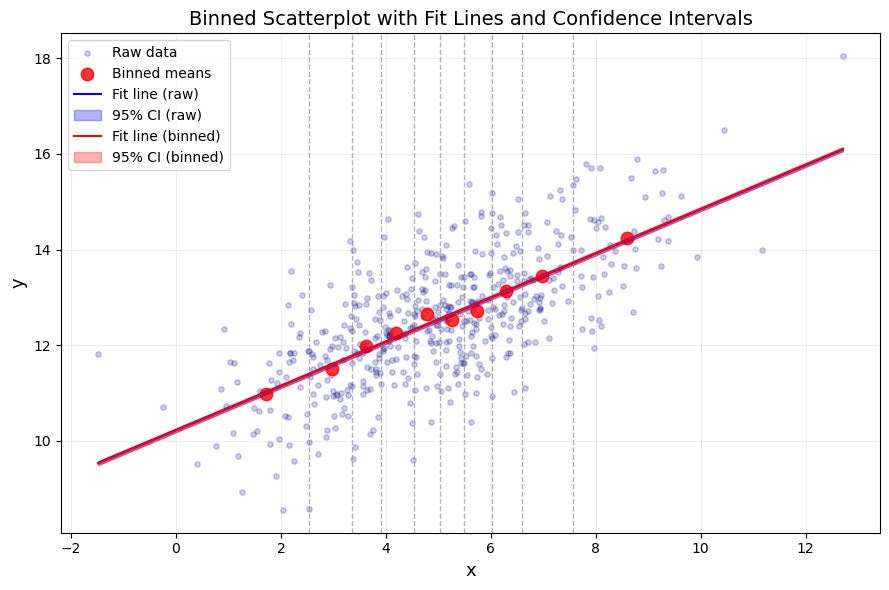

In [93]:
import numpy as np
import pandas as pd
from scipy import stats

import matplotlib.pyplot as plt

# 1. 生成模拟数据
np.random.seed(42)
n = 500
x = np.random.normal(5, 2, n)
e = np.random.normal(0, 1, n)
y = 10 + 0.5 * x + e

df_sim = pd.DataFrame({'x': x, 'y': y})

# 2. 分为10组（十分位分组）
df_sim['bin'], bin_edges = pd.qcut(df_sim['x'], 10, labels=False, retbins=True, duplicates='drop')

# 3. 计算每组均值
grouped = df_sim.groupby('bin').agg(
    mean_x=('x', 'mean'),
    mean_y=('y', 'mean')
).reset_index()

# 4. 原始数据的拟合线与置信区间
slope, intercept, r_value, p_value, std_err = stats.linregress(df_sim['x'], df_sim['y'])
x_line = np.linspace(df_sim['x'].min(), df_sim['x'].max(), 200)
y_line = intercept + slope * x_line

# 置信区间
y_pred = intercept + slope * df_sim['x']
resid = df_sim['y'] - y_pred
se = np.sqrt(np.sum(resid**2) / (n - 2)) / np.sqrt(np.sum((df_sim['x'] - df_sim['x'].mean())**2))
ci = 1.96 * se
y_upper = y_line + ci
y_lower = y_line - ci

# 5. 分仓均值的拟合线与置信区间
slope_bin, intercept_bin, _, _, std_err_bin = stats.linregress(grouped['mean_x'], grouped['mean_y'])
y_line_bin = intercept_bin + slope_bin * x_line
# 置信区间（近似，使用分组均值的标准误）
y_pred_bin = intercept_bin + slope_bin * grouped['mean_x']
resid_bin = grouped['mean_y'] - y_pred_bin
se_bin = np.sqrt(np.sum(resid_bin**2) / (len(grouped) - 2)) / np.sqrt(np.sum((grouped['mean_x'] - grouped['mean_x'].mean())**2))
ci_bin = 1.96 * se_bin
y_upper_bin = y_line_bin + ci_bin
y_lower_bin = y_line_bin - ci_bin

# 6. 绘图
plt.figure(figsize=(9, 6))
plt.scatter(df_sim['x'], df_sim['y'], color='darkblue', alpha=0.2, s=15, label='Raw data')
plt.scatter(grouped['mean_x'], grouped['mean_y'], color='red', alpha=0.8, s=80, label='Binned means')

# 分仓线
for edge in bin_edges[1:-1]:
    plt.axvline(edge, color='grey', linestyle='dashed', linewidth=1, alpha=0.6)

# 原始数据拟合线和置信区间
plt.plot(x_line, y_line, color='blue', label='Fit line (raw)')
plt.fill_between(x_line, y_lower, y_upper, color='blue', alpha=0.3, label='95% CI (raw)')

# 分仓均值拟合线和置信区间
plt.plot(x_line, y_line_bin, color='red', label='Fit line (binned)')
plt.fill_between(x_line, y_lower_bin, y_upper_bin, color='red', alpha=0.3, label='95% CI (binned)')

plt.xlabel('x', fontsize=13)
plt.ylabel('y', fontsize=13)
plt.title('Binned Scatterplot with Fit Lines and Confidence Intervals', fontsize=14)
plt.legend(fontsize=10)
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()

### 回归结果对比

::: {.callout-tip}
### 提示词

做两个回归，列表呈现回归结果：

1. data = df_sim
2. 原始数据回归：$y = \beta_0 + \beta_1 x + e$
3. 分仓散点图回归：$\bar{y}_g = \theta_0 + \theta_1 \bar{x}_g + u$
4. 回归结果表格中包含：b、se、t、p值、N, R2。
:::


In [94]:
import pandas as pd

import statsmodels.api as sm

# 原始数据回归
X_raw = sm.add_constant(df_sim['x'])
model_raw = sm.OLS(df_sim['y'], X_raw).fit()

# 分仓均值回归
X_bin = sm.add_constant(grouped['mean_x'])
model_bin = sm.OLS(grouped['mean_y'], X_bin).fit()

# 整理结果
def summary_to_dict(model, N):
    params = model.params
    bse = model.bse
    tvalues = model.tvalues
    pvalues = model.pvalues
    rsq = model.rsquared
    return {
        'b': params.values,
        'se': bse.values,
        't': tvalues.values,
        'P>|t|': pvalues.values,
        'N': [N, ''],
        'R2': [rsq, '']
    }

res_raw = summary_to_dict(model_raw, len(df_sim))
res_bin = summary_to_dict(model_bin, len(grouped))

# 合并为表格
index = ['Intercept', 'x']
results_df = pd.DataFrame({
    ('Raw', col): res_raw[col] for col in res_raw
}, index=index)
for col in res_bin:
    results_df[('Binned', col)] = res_bin[col]

# 展示结果
print(results_df.round(3).T)

             Intercept       x
Raw    b        10.221   0.462
       se         0.12   0.022
       t        85.265  20.761
       P>|t|       0.0     0.0
       N           500        
       R2     0.463953        
Binned b        10.215   0.463
       se        0.107    0.02
       t        95.734  23.307
       P>|t|       0.0     0.0
       N            10        
       R2     0.985486        


可以看出：

1. 原始数据回归与分仓散点图回归的斜率估计非常接近，说明分组均值并不会改变 $x$ 对 $y$ 的主效应估计。
2. 分仓散点图回归的标准误略大于原始回归，这是因为分组后有效观测数大幅减少，估计的不确定性相对提高（尽管分组均值降低了部分噪音）。
3. 分仓散点图回归的 $R^2$ 显著高于原始回归，反映出分组均值有效去除了大量噪声，突出了 $x$ 与 $y$ 的主干趋势。

### 例 2：实际数据-教育回报率

此处，我们使用实际数据集（如教育回报率）来演示分仓散点图的应用。

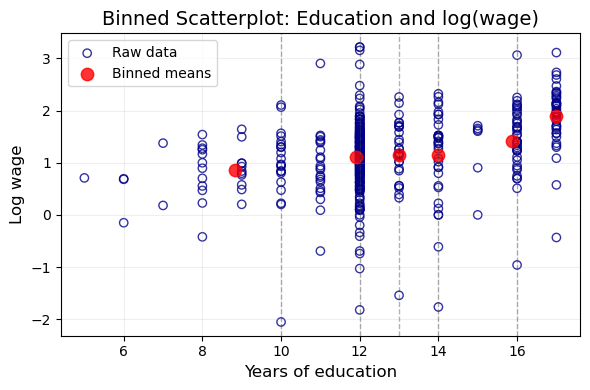

In [95]:
import pandas as pd
import matplotlib.pyplot as plt

# 在线读取数据
url = "https://vincentarelbundock.github.io/Rdatasets/csv/wooldridge/mroz.csv"
df_edu = pd.read_csv(url)

x = "educ"
y = "lwage"

df_edu = df_edu[[x, y]].dropna().copy()

# 分组
df_edu['bin'], bin_edges = pd.qcut(df_edu[x], 10, labels=False, 
                                   retbins=True, duplicates='drop')

plt.figure(figsize=(6, 4))
plt.scatter(df_edu[x], df_edu[y], marker='o', facecolors='none', 
            edgecolors='darkblue', alpha=0.8, label='Raw data')

bin_means = df_edu.groupby('bin').agg(
    mean_x=(x, 'mean'),
    mean_y=(y, 'mean')
).reset_index()

plt.scatter(bin_means['mean_x'], bin_means['mean_y'], 
            color='red', alpha=0.8, s=80, label='Binned means')

for edge in bin_edges[1:-1]:
    plt.axvline(edge, color='black', linestyle='dashed', 
                linewidth=1, alpha=0.3)

plt.xlabel('Years of education', fontsize=12)
plt.ylabel('Log wage', fontsize=12)
plt.title('Binned Scatterplot: Education and log(wage)', fontsize=14)
plt.legend(fontsize=10)
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()


分别用原始数据 (df_edu) 和分仓散点数据 (bin_means) 进行 OLS 回归，列表对比结果。

In [96]:
import statsmodels.api as sm

# 原始数据回归
X_raw = sm.add_constant(df_edu['educ'])
model_raw = sm.OLS(df_edu['lwage'], X_raw).fit()

# 分仓均值回归
X_bin = sm.add_constant(bin_means['mean_x'])
model_bin = sm.OLS(bin_means['mean_y'], X_bin).fit()

# 整理结果
def summary_to_dict(model, N):
    params = model.params
    bse = model.bse
    tvalues = model.tvalues
    pvalues = model.pvalues
    rsq = model.rsquared
    return {
        'b': params.values,
        'se': bse.values,
        't': tvalues.values,
        'P>|t|': pvalues.values,
        'N': [N, ''],
        'R2': [rsq, '']
    }

res_raw = summary_to_dict(model_raw, len(df_edu))
res_bin = summary_to_dict(model_bin, len(bin_means))

# 合并为表格
index = ['Intercept', 'educ']
results_df_edu = pd.DataFrame({
    ('Raw', col): res_raw[col] for col in res_raw
}, index=index)
for col in res_bin:
    results_df_edu[('Binned', col)] = res_bin[col]

# 展示结果
print(results_df_edu.round(3).T)

             Intercept   educ
Raw    b        -0.185  0.109
       se        0.185  0.014
       t          -1.0  7.545
       P>|t|     0.318    0.0
       N           428       
       R2     0.117883       
Binned b        -0.234  0.112
       se         0.36  0.026
       t         -0.65  4.247
       P>|t|     0.551  0.013
       N             6       
       R2     0.818467       



## 理论基础

### 条件期望角度的解释

在概率与统计中，**条件期望** $E(y|x)$ 指的是在给定 $x$ 取某一值或落入某一区间时，$y$ 的平均值。具体来说：

* 理论上，$E(y|x)$ 能完整反映 $y$ 随 $x$ 变化的均值趋势。这是理解 $x$ 如何影响 $y$ 的基础，也是回归、因果推断等分析的理论起点。
* 实际数据有限且带有噪音，无法对每一个 $x$ 逐点估计 $E(y|x)$。

分仓散点图的思想是：

* 将 $x$ 按分位点或等宽区间划分为 $G$ 个组，每组编号 $g=1,2,\ldots,G$；
* 在每组内，计算 $x$ 和 $y$ 的均值 $\bar{x}_g, \bar{y}_g$，以 $(\bar{x}_g, \bar{y}_g)$ 作为代表；
* 这些分组均值点就是 $E(y|x \in g)$ 的经验近似。

数学表达如下：

$$
\bar{y}_g = \frac{1}{n_g} \sum_{i \in g} y_i \approx E(y|x \in g)
$$

其中 $n_g$ 是第 $g$ 组的观测数，$i \in g$ 表示第 $i$ 个观测属于该组。

那么，为什么分组均值可以近似条件期望？

* 在每个小区间 $x \in g$ 内，$x$ 的变化较小，$\bar{y}_g$ 就是 $y$ 在 $x$ 落入该区间时的平均水平；
* 分组数量足够多时，$(\bar{x}_g, \bar{y}_g)$ 可以密集覆盖 $E(y|x)$ 曲线；
* 分组数过多或过少都会影响估计精度，需要结合样本量和研究目标设定。

![](https://fig-lianxh.oss-cn-shenzhen.aliyuncs.com/Stata：binscatter和binscatter2命令简介_Fig4_条件期望函数_钟声.png)

> Source: Stepner M. Binscatter: Binned scatterplots in stata[J]. StataConference, 2014. [-PDF-](https://michaelstepner.com/binscatter/binscatter-StataConference2014.pdf)

### 图示



以 bin 为分组变量，绘制 wage 的如下图形：
- 各组的小提琴图，但不用显示中位数和胡虚线。
- 各组的散点图 (marker = 'o', alpha = 0.5, 蓝色)。
- 各组的均值点 (实心圆点，红色) + 均值点连接线 (实线，红色)。

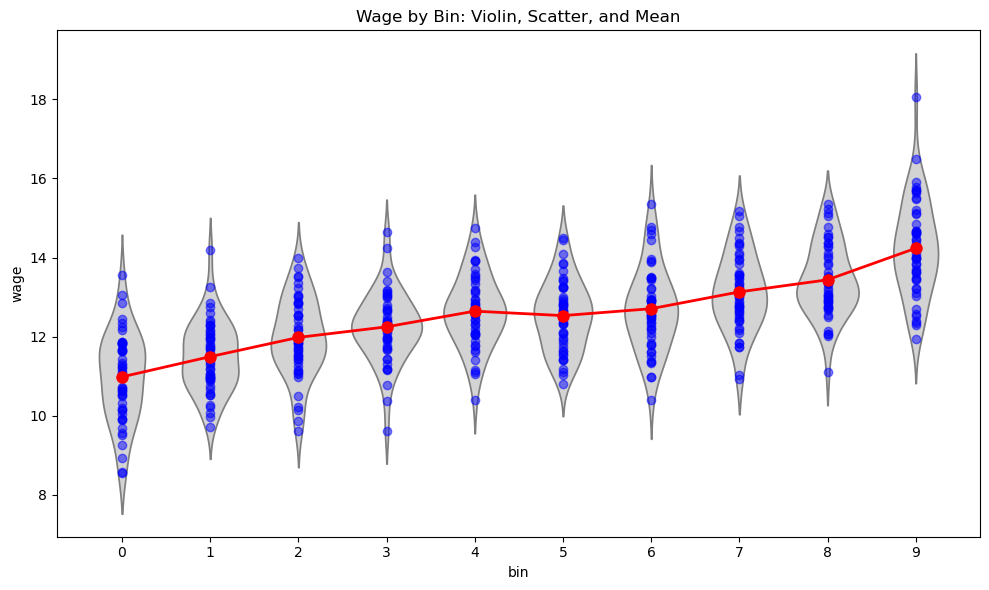

In [97]:
import numpy as np
import pandas as pd
from scipy import stats

import matplotlib.pyplot as plt

# 1. 生成模拟数据
np.random.seed(42)
n = 500
x = np.random.normal(5, 2, n)
e = np.random.normal(0, 1, n)
y = 10 + 0.5 * x + e

df_sim = pd.DataFrame({'x': x, 'y': y})

# 2. 分为10组（十分位分组）
df_sim['bin'], bin_edges = pd.qcut(df_sim['x'], 10, labels=False, retbins=True, duplicates='drop')

# 3. 绘图
plt.figure(figsize=(10, 6))

# 小提琴图（不显示中位数和胡须线）
sns.violinplot(
    x='bin', y='y', data=df_sim, inner=None, color='lightgray'
)

# 各组散点图
plt.scatter(df_sim['bin'], df_sim['y'], marker='o', alpha=0.5, color='blue', label='Scatter')

# 各组均值点和连接线
group_mean = df_sim.groupby('bin')['y'].mean()
plt.plot(group_mean.index, group_mean.values, color='red', marker='o', markersize=8, linewidth=2, label='Mean')

plt.xlabel('bin')
plt.ylabel('wage')
plt.title('Wage by Bin: Violin, Scatter, and Mean')
plt.tight_layout()
plt.show()

### 条件期望的扩展（考虑控制变量）

在多元分析中，我们关心 $x$ 与 $y$ 的关系时，往往需要控制其他变量 $z$，即关注 $E(y|x, z)$。对应的多元回归模型通常设定为：

$$
y_i = \alpha + \beta x_i + \gamma z_i + e_i \tag{1}
$$

* $E(y|x, z)$ 描述的是在 $z$ 固定时，给定 $x$ 对应的 $y$ 的期望值。
* 多数情况下，$corr(x, z) \neq 0$，即 $x$ 和 $z$ 之间存在相关性。这意味着 $E(y|x, z) \neq E(y|x)$。因此，直接绘制 $E(y|x)$ 的分仓散点图无法反应 $E(y|x, z)$ 的真实关系。

那么，如何在控制 变量 $z$ 的情况下估计 $E(y|x, z)$ 呢？

#### FWL 定理（残差法）

1. 用 $y$ 对 $z$ 回归，得到残差 $\tilde{y}$，即去除了 $y$ 中受 $z$ 影响的部分；
2. 用 $x$ 对 $z$ 回归，得到残差 $\tilde{x}$，即去除了 $x$ 中受 $z$ 影响的部分；
3. 对 $\tilde{x}$ 分组，计算每组 $\tilde{y}$ 的均值 $(\bar{\tilde{x}}_g, \bar{\tilde{y}}_g)$；
4. 以 $(\bar{\tilde{x}}_g, \bar{\tilde{y}}_g)$ 作图，可以近似 $E(y|x, z)$。

表达式如下：

$$
\tilde{y}_i = y_i - E(y|z_i)
$$

$$
\tilde{x}_i = x_i - E(x|z_i)
$$

每组均值 $\bar{\tilde{y}}_g$ 就近似于 $E(y|x, z)$ 在该分组下的条件期望。

有关 FWL 定理的详细介绍，请参见：

- 胡雨霄, 2020, [图示线性回归系数：Frisch-Waugh-Lovell定理与部分回归图](https://www.lianxh.cn/details/113.html), 连享会 No.113.
- 胡雨霄, 2020, [R2分解：相对重要性分析 (Dominance Analysis)](https://www.lianxh.cn/details/52.html), 连享会 No.52.


![](https://fig-lianxh.oss-cn-shenzhen.aliyuncs.com/OLS-FWL-venn.png)



## 几个问题

### 为何要采用等分组？

细心的读者可能已经注意到，在上述例子中，我们都采用了等分组的方式。即将 $x$ 的取值范围分为 $G$ 个相等的区间，每个区间内的样本数尽可能相同。这种方法有几个优点：

1. **均衡样本量**：每组的样本数相近，避免某些组过于稀疏导致估计不稳定。
2. **简化计算**：由于每个组的样本数相同，当我们基于组均值进行回归时，无需调整权重或考虑样本量差异。如果以 $x$ 的取值范围进行分组，会导致每个组中的样本数都不同，那么用 $\bar{y}_g$ 与 $\bar{x}_g$ 进行回归时，就需要对每个组的样本量进行加权，计算复杂度会增加。


### 如何选择 bins 的数量？

构建分仓散点图时，分仓数量（$G$）的选择至关重要。分仓数较多时，可以更细致地揭示 $x$ 与 $y$ 之间的非线性关系，但每个分组内的数据点变少，导致估计的方差增大，结果更易受偶然波动影响。反之，分仓数较少时，每组包含的数据点更多，估计更稳定，但可能掩盖了变量之间的复杂结构和非线性趋势。这实际上是“方差-偏差权衡”（variance-bias tradeoff）问题：$G$ 越大，偏差越小但方差越大；$G$ 越小，方差减小但偏差可能增大。因此，分仓数量的选择应结合样本量、变量分布和分析目标进行权衡与调整。

在 Stepner (2014) 编写的 Stata 命令 `binscatter` 中，$G$ 的默认值为 20。Stepner 称，根据他的个人经验，这一数值的表现较好。

[Cattaneo](https://doi.org/10.1257/aer.20221576) et al. ([2024](https://nppackages.github.io/references/Cattaneo-Crump-Farrell-Feng_2024_AER.pdf), AER) 的理论分析表明，使综合均方误差最小化的分仓数 $G$ 与 $n^{1 /3}$ 成正比 ($n$ 为样本数)。因此，观测值越大，$G$ 的取值越大。不过，其他因素也很重要。例如，保持 $x$ 的分布不变，$x$ 和 $y$ 之间的关系曲线越复杂，$G$ 的取值也应该越大 (否则均方误差会增加)。

| $n$  | $n^{1/3}$ |
| ------:| ----------- |
| 1,000   | 10.0        |
| 5,000   | 17.1        |
| 10,000  | 21.5        |
| 100,000 | 46.4        |

根据上表，多数情况下，取 $G$ 为 10-20 是合适的。对于大样本（如 $n > 10,000$），可以考虑增加到 30-50，但需要注意避免过拟合和噪音干扰。




## Python 实例

在劳动经济学中，一个核心问题是：工人的工资 $Y$ 由什么因素决定？虽然这是一个因果推断问题，但我们可以先从预测的角度进行分析。

在下面的工资案例中，$Y$ 表示工人的（对数）小时工资，$X$ 是工人的特征向量，例如教育、工作经验、性别等。这里我们关注两个主要问题：

* 如何利用与工作相关的特征（如教育和经验）更好地预测工资 $Y$？
* 在其他工作相关特征 $X$ 相同的情况下，男性和女性工人的预测工资有何不同？

本实验首先聚焦于预测问题。

### 数据说明

本次分析的数据来源于 2015 年美国现行人口调查（CPS）三月补充调查。我们筛选了 25 至 64 岁的白人非西班牙裔个体，要求每年工作超过 50 周且每周工作时间超过 35 小时。排除了自雇人员、居住在集体宿舍的个体、军人、农业或私人家庭部门的个体，以及在收入和就业状态报告上存在不一致、变量有缺失或分配信息的观测，同时剔除了小时工资低于 3 的样本。

我们关注的核心变量 $Y$，即（对数）小时工资率，是由年收入除以总工作小时数得到的。其中，总工作小时数等于每年工作周数乘以每周通常工作小时数。在分析中，我们还聚焦于未婚（从未结婚）工人。最终样本量为 $n=5150$。

> **Source**: Chernozhukov, V. & Hansen, C. & Kallus, N. & Spindler, M. & Syrgkanis, V. (**2024**): Applied Causal Inference Powered by ML and AI. [CausalML-book.org](https://causalml-book.org/); arXiv:2403.02467. [-PDF-](https://arxiv.org/pdf/2403.02467)，[Website](https://causalml-book.org/), [github](https://github.com/CausalAIBook/MetricsMLNotebooks) &rarr; [This Note](https://github.com/CausalAIBook/MetricsMLNotebooks/blob/main/PM1/python-ols-and-lasso-for-wage-prediction.ipynb) 

#### 变量标签与变量解释

下面列示了该数据集中每个变量的常用英文标签及中文解释说明。部分变量根据 CPS 典型设定和相关代码本推断并补充。


| 变量名   | 英文标签                         | 中文解释                          |
| -- | - | -- |
| wage  | Hourly wage                  | 小时工资（美元）                      |
| lwage | Log hourly wage              | 小时工资的对数                       |
| sex   | Female (1=Female)            | 性别（女性=1，男性=0）                 |
| shs   | <12 years of schooling       | 教育年限未满 12 年（未完成高中）            |
| hsg   | High school graduate         | 高中毕业                          |
| scl   | Some college                 | 大学肄业（上过大学但未获得学位）              |
| clg   | College graduate             | 大学毕业（获得学士学位）                  |
| ad    | Advanced degree              | 研究生学历（硕士或博士）                  |
| mw    | Midwest region               | 美国中西部地区（居住地）                  |
| so    | South region                 | 美国南部地区（居住地）                   |
| we    | West region                  | 美国西部地区（居住地）                   |
| ne    | Northeast region             | 美国东北地区（居住地）                   |
| exp1  | Potential experience         | 潜在工作经验年数（age - education - 6） |
| exp2  | Potential experience squared | 潜在工作经验年数的平方                   |
| exp3  | Potential experience cubed   | 潜在工作经验年数的三次方                  |
| exp4  | Potential experience^4       | 潜在工作经验年数的四次方                  |
| occ   | Occupation code              | 职业代码（细分，通常为 3-5 位数）           |
| occ2  | Major occupation group       | 职业大类代码（22 类）                  |
| ind   | Industry code                | 行业代码（细分，通常为 3-5 位数）           |
| ind2  | Major industry group         | 行业大类代码（22 类）                  |


#### 变量进一步解释和常见分组

* **学历变量（shs, hsg, scl, clg, ad）**
  这些是**互斥**的 dummy 变量，每个人只能属于其中一个。常见定义如下：

  * `shs`: 小于高中毕业（未完成高中学业）
  * `hsg`: 高中毕业但没有上过大学
  * `scl`: 上过大学但未毕业（包括两年制大学、部分大学课程等，未获得学位）
  * `clg`: 获得学士学位（本科毕业）
  * `ad`: 获得更高学位（硕士及以上）

* **地区变量（mw, so, we, ne）**
  根据居住地划分的美国四大区域，具体可以参考美国人口调查标准地区定义。

* **经验变量（exp1, exp2, exp3, exp4）**
  经验变量通常由公式 $exp1 = \text{age} - \text{years of schooling} - 6$ 计算，近似代表进入劳动力市场的年数，其高次项常用于工资方程中的经验-工资非线性关系建模。

* **职业/行业变量（occ, occ2, ind, ind2）**

  * `occ`/`ind` 为细分的职业/行业代码，通常来自于 CPS 的详细分类。
  * `occ2`/`ind2` 则为大类分组，便于建模和控制大类异质性。


#### 参考说明与代码本依据

这些变量的定义可参考 CPS（Current Population Survey）文档和相关学术论文，例如：

- Angrist, J. D., & Pischke, J.-S. (2009). *Mostly Harmless Econometrics: An Empiricist's Companion*. Princeton University Press. [Link](https://press.princeton.edu/books/paperback/9780691120355/mostly-harmless-econometrics), [Google](https://scholar.google.com/scholar?q=Mostly+Harmless+Econometrics).
- Card, D., & Krueger, A. B. (1992). School Quality and Black-White Relative Earnings: A Direct Assessment. *Quarterly Journal of Economics*, 107(1), 151–200. [Link](https://doi.org/10.2307/2118323), [PDF](http://sci-hub.ren/10.2307/2118323), [Google](https://scholar.google.com/scholar?q=School+Quality+and+Black-White+Relative+Earnings).



### 初步分析

In [98]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import sklearn.linear_model as lm
import statsmodels.formula.api as smf
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import warnings
# ignore potential convergence warnings; for some small penalty levels,
# tried out, optimization might not converge
warnings.simplefilter('ignore')

In [70]:
file = "https://raw.githubusercontent.com/CausalAIBook/MetricsMLNotebooks/main/data/wage2015_subsample_inference.csv"
df = pd.read_csv(file)

df.columns

Index(['wage', 'lwage', 'sex', 'shs', 'hsg', 'scl', 'clg', 'ad', 'mw', 'so',
       'we', 'ne', 'exp1', 'exp2', 'exp3', 'exp4', 'occ', 'occ2', 'ind',
       'ind2'],
      dtype='object')

#### 变量生成及变量标签

在本节中，我们将对数据集进行变量生成和标签定义，以便后续分析和建模。

- 基于 sex 生成新变量：带标签的变量 sex_label
  - `sex_label`：{0: Male; 1: Female}，表示性别。我们将其转换为字符串标签。

- 教育水平和地区
  - 定义一个新变量：edu_group，表示教育水平的分组，取值为 `{'shs': '<HS', 'hsg': 'HS', 'scl': 'Some College', 'clg': 'College', 'ad': 'Advanced'}`。后续分析中采用这个变量更便于分组绘图和统计分析。
  - 定义一个新变量：regeion，表示居住地区的分组，取值为 `{'mw': 'Midwest', 'so': 'South', 'we': 'West', 'ne': 'Northeast'}`。后续分析中采用这个变量更便于分组绘图和统计分析。



In [100]:
# 基于 sex 生成 sex_label 变量（0: Male, 1: Female），并转换为字符串标签
df['sex_label'] = df['sex'].map({0: 'Male', 1: 'Female'})

# 定义 edu_group 变量
edu_map = {'shs': '<HS', 'hsg': 'HS', 'scl': 'Some College', 'clg': 'College', 'ad': 'Advanced'}
def get_edu_group(row):
    for k in edu_map:
        if row[k] == 1:
            return edu_map[k]
    return None
df['edu_group'] = df.apply(get_edu_group, axis=1)

# 定义 region 变量
region_map = {'mw': 'Midwest', 'so': 'South', 'we': 'West', 'ne': 'Northeast'}
def get_region(row):
    for k in region_map:
        if row[k] == 1:
            return region_map[k]
    return None
df['region'] = df.apply(get_region, axis=1)

# 变量清单
df.columns

Index(['wage', 'lwage', 'sex', 'shs', 'hsg', 'scl', 'clg', 'ad', 'mw', 'so',
       'we', 'ne', 'exp1', 'exp2', 'exp3', 'exp4', 'occ', 'occ2', 'ind',
       'ind2', 'sex_label', 'edu_group', 'region'],
      dtype='object')

In [73]:
# 描述性统计量
cols_to_exclude = ['exp2', 'exp3', 'exp4', 'occ', 'ind']
desc = df.drop(columns=cols_to_exclude).describe().T[['count', 'mean', 'std', 'min', 'max']]
desc = desc.rename(columns={'count': 'N', 'std': 'sd'})
print(desc.round(2))

            N   mean     sd   min     max
wage   5150.0  23.41  21.00  3.02  528.85
lwage  5150.0   2.97   0.57  1.11    6.27
sex    5150.0   0.44   0.50  0.00    1.00
shs    5150.0   0.02   0.15  0.00    1.00
hsg    5150.0   0.24   0.43  0.00    1.00
scl    5150.0   0.28   0.45  0.00    1.00
clg    5150.0   0.32   0.47  0.00    1.00
ad     5150.0   0.14   0.34  0.00    1.00
mw     5150.0   0.26   0.44  0.00    1.00
so     5150.0   0.30   0.46  0.00    1.00
we     5150.0   0.22   0.41  0.00    1.00
ne     5150.0   0.23   0.42  0.00    1.00
exp1   5150.0  13.76  10.61  0.00   47.00
occ2   5150.0  11.67   6.97  1.00   22.00
ind2   5150.0  13.32   5.70  2.00   22.00


### 分仓散点图


#### 原始数据散点图：wage 与 experience 的关系

- 绘制 wage 和 experience 的 '散点图+线性回归线 (+ 95% CI)' 图。
- 绘制 wage 和 experience 的 '散点图+二次曲线拟合线 (+ 95% CI)' 图。(省略了)


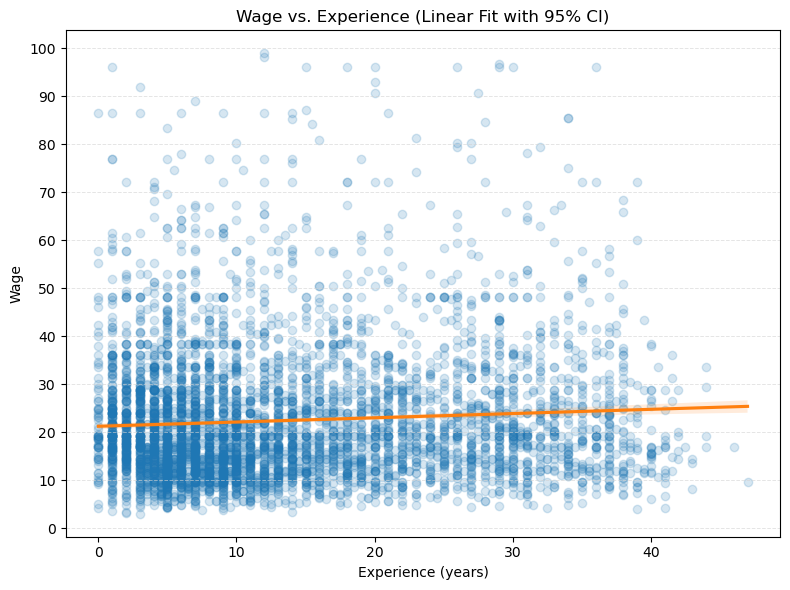

In [101]:
# 绘制 wage 和 experience 的 '散点图+线性回归线 (+ 95% CI)' 图。

import seaborn as sns
import numpy as np

import matplotlib.pyplot as plt

# 只用 wage < 100 的样本
df_plot = df[df['wage'] < 100].copy()

plt.figure(figsize=(8, 6))
sns.regplot(
    data=df_plot,
    x='exp1', y='wage',
    scatter_kws={'alpha': 0.18, 'color': '#1f77b4'},
    line_kws={'color': '#ff7f0e'},
    ci=95
)
plt.xlabel('Experience (years)')
plt.ylabel('Wage')
plt.title('Wage vs. Experience (Linear Fit with 95% CI)')
plt.grid(axis='y', color='lightgray', linestyle='--', linewidth=0.7, alpha=0.6)
plt.yticks(np.arange(0, 105, 10))
plt.tight_layout()
plt.show()


#### 分仓散点图

- 绘制 wage 和 experience 的 '分仓散点图 (binscatter)+线性回归线 (+ 95% CI)' 图。

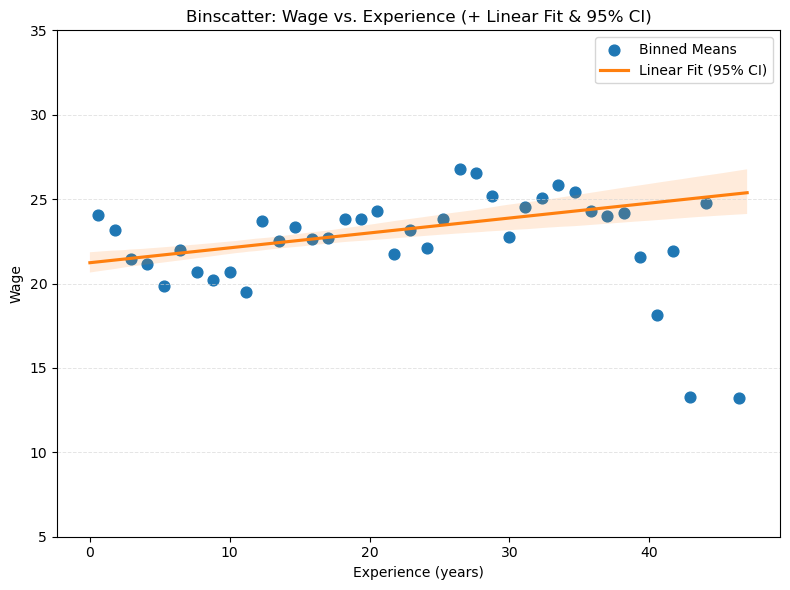

In [75]:
import seaborn as sns
import numpy as np
from scipy.stats import binned_statistic

import matplotlib.pyplot as plt

# 只用 wage < 100 的样本
df_plot = df[df['wage'] < 100].copy()

# 设置分箱数量
n_bins = 40
bin_means, bin_edges, binnumber = binned_statistic(
    df_plot['exp1'], df_plot['wage'], statistic='mean', bins=n_bins
)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

plt.figure(figsize=(8, 6))
# 绘制分仓均值散点
plt.scatter(bin_centers, bin_means, color='#1f77b4', s=60, label='Binned Means')

# 拟合线性回归线和置信区间
sns.regplot(
    data=df_plot,
    x='exp1', y='wage',
    scatter=False,
    line_kws={'color': '#ff7f0e'},
    ci=95,
    label='Linear Fit (95% CI)'
)

plt.xlabel('Experience (years)')
plt.ylabel('Wage')
plt.title('Binscatter: Wage vs. Experience (+ Linear Fit & 95% CI)')
plt.grid(axis='y', color='lightgray', linestyle='--', linewidth=0.7, alpha=0.6)
plt.yticks(np.arange(5, 40, 5))
plt.legend()
plt.tight_layout()
plt.show()

### 分仓非线性拟合线

::: {.callout-tip}
### 提示词

绘制 wage 和 experience 的 '分仓散点图 (binscatter)' 图：

- bins = 20 
- 添加非线性拟合线和 95% CI，多项式阶数 p 选择最优值
- y 轴刻度：5(5)40
:::

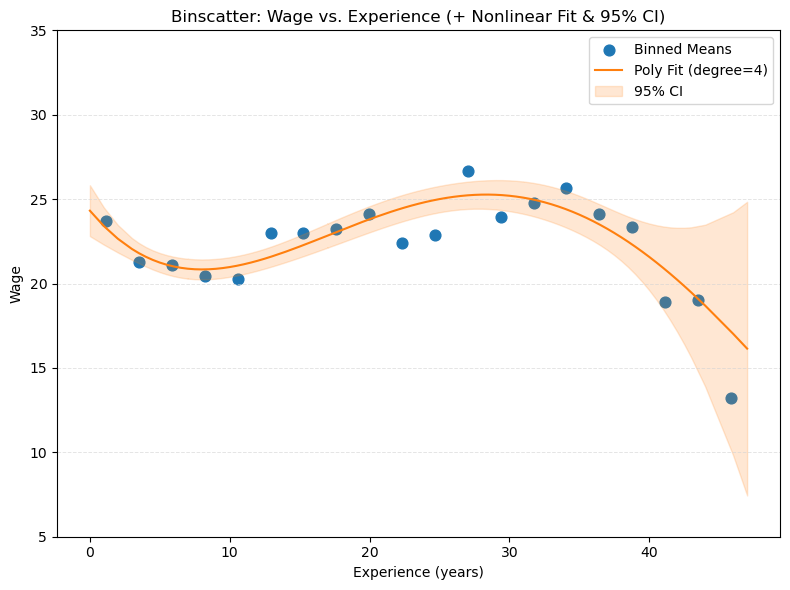

In [76]:
import numpy as np
import seaborn as sns
from scipy.stats import binned_statistic
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from statsmodels.stats.outliers_influence import summary_table

import matplotlib.pyplot as plt

# 只用 wage < 100 的样本
df_plot = df[df['wage'] < 100].copy()

# 分箱参数
n_bins = 20
bin_means, bin_edges, binnumber = binned_statistic(
    df_plot['exp1'], df_plot['wage'], statistic='mean', bins=n_bins
)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# 选择最优多项式阶数（交叉验证，最大到5阶）
X = df_plot[['exp1']].values
y = df_plot['wage'].values
cv_scores = []
degrees = range(1, 6)
for d in degrees:
    poly = PolynomialFeatures(degree=d)
    X_poly = poly.fit_transform(X)
    model = LinearRegression()
    # 负MSE，取均值
    score = cross_val_score(model, X_poly, y, cv=5, scoring='neg_mean_squared_error').mean()
    cv_scores.append(score)
best_degree = degrees[np.argmax(cv_scores)]

# 用最优阶数拟合
poly = PolynomialFeatures(degree=best_degree)
X_poly = poly.fit_transform(X)
model = LinearRegression().fit(X_poly, y)
y_pred = model.predict(X_poly)

# 计算置信区间
import statsmodels.api as sm
X_poly_sm = sm.add_constant(X_poly)
ols = sm.OLS(y, X_poly_sm).fit()
st, data, ss2 = summary_table(ols, alpha=0.05)
ci_low, ci_upp = data[:, 4], data[:, 5]

# 绘图
plt.figure(figsize=(8, 6))
plt.scatter(bin_centers, bin_means, color='#1f77b4', s=60, label='Binned Means')
# 拟合曲线
order = np.argsort(X[:, 0])
plt.plot(X[order, 0], y_pred[order], color='#ff7f0e', label=f'Poly Fit (degree={best_degree})')
plt.fill_between(X[order, 0], ci_low[order], ci_upp[order], color='#ff7f0e', alpha=0.18, label='95% CI')
plt.xlabel('Experience (years)')
plt.ylabel('Wage')
plt.title('Binscatter: Wage vs. Experience (+ Nonlinear Fit & 95% CI)')
plt.grid(axis='y', color='lightgray', linestyle='--', linewidth=0.7, alpha=0.6)
plt.yticks(np.arange(5, 40, 5))
plt.legend()
plt.tight_layout()
plt.show()

从图中似乎可以看到如下结果：

1. 工资与经验之间存在非线性关系，甚至出现了波浪形的变化关系。
2. 在数据分析中，我们应该将注意力放在「多数样本」上，因此，如果不考虑左侧的三个样本点 (工龄不足 5 年的样本) 和右侧的三个样本点 (工龄超过 40 年的样本)，工资与经验之间的关系大体上呈现出「倒 U 型关系」。这与我们的常识基本相符：工龄较短时，工资随着经验的增加而增加；工龄达到一定程度后，工资增长速度减缓甚至可能下降。
3. 更为重要的是，上述关系并未考虑其他变量的影响，因此我们需要进一步控制其他变量（如教育水平、性别等）来更准确地分析工资与经验之间的关系。

#### 性别差异

::: {.callout-tip}
### 提示词

定义一个函数，`plot_binscatter_by()`：

- df, xvar, yvar 
- groupvar='group variable name'
- 绘制 y ~ x 分仓非线性拟合线，p = 4 (default)
- 针对 groupvar 变量的每个取值，绘制分仓散点图和拟合线
- 图例：使用 groupvar 的标签；仅呈现 binned 的标签，不用显示 bins fit 的标签，否则图例会占据太大面积
:::

In [92]:
import numpy as np
from scipy.stats import binned_statistic
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import seaborn as sns

def plot_binscatter_by(df, xvar, yvar, groupvar, n_bins=20, degree=4, palette=None, scatter_alpha=0.18, scatter_size=50, figsize=(8, 6)):
    """
    分组分仓散点图 + 多项式拟合线（默认4阶），每个分组单独绘制。
    """
    import matplotlib.pyplot as plt
    import statsmodels.api as sm

    groups = df[groupvar].dropna().unique()
    if palette is None:
        colors = sns.color_palette("tab10", len(groups))
        palette = {g: c for g, c in zip(groups, colors)}

    plt.figure(figsize=figsize)
    for group in groups:
        sub = df[df[groupvar] == group]
        x = sub[xvar].values
        y = sub[yvar].values

        # 分箱均值
        bin_means, bin_edges, _ = binned_statistic(x, y, statistic='mean', bins=n_bins)
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        plt.scatter(bin_centers, bin_means, color=palette[group], s=scatter_size, alpha=0.8, label=f'{group} (binned)')

        # 多项式拟合
        poly = PolynomialFeatures(degree=degree)
        X_poly = poly.fit_transform(x.reshape(-1, 1))
        model = LinearRegression().fit(X_poly, y)
        x_fit = np.linspace(x.min(), x.max(), 200)
        X_fit_poly = poly.transform(x_fit.reshape(-1, 1))
        y_fit = model.predict(X_fit_poly)

        # 置信区间
        X_poly_sm = sm.add_constant(X_poly)
        ols = sm.OLS(y, X_poly_sm).fit()
        X_fit_poly_sm = sm.add_constant(X_fit_poly)
        prstd, ci_low, ci_upp = wls_prediction_std(ols, exog=X_fit_poly_sm, alpha=0.05)
        plt.plot(x_fit, y_fit, color=palette[group], label=f'{group} (poly fit)')
        plt.fill_between(x_fit, ci_low, ci_upp, color=palette[group], alpha=0.15)

    plt.xlabel(xvar)
    plt.ylabel(yvar)
    plt.title(f'Binscatter: {yvar} vs. {xvar} by {groupvar} (Poly p={degree})')
    plt.grid(axis='y', color='lightgray', linestyle='--', linewidth=0.7, alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()

::: {.callout-tip}
### 提示词

使用上述 `plot_binscatter_by` 函数绘图：在同一幅图中，绘制 Male 和 Female 的分仓散点图和拟合线。
:::


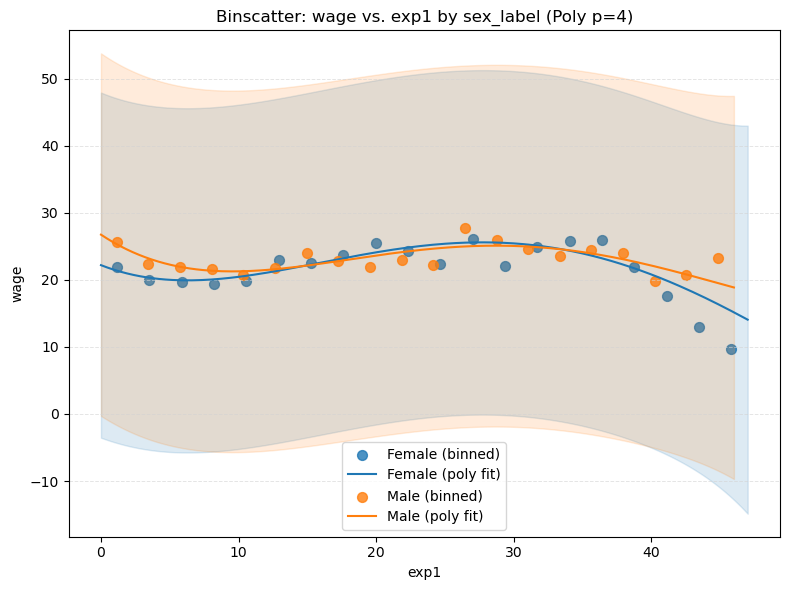

In [78]:
# 定义 df_wage_less_100，确保只包含 wage < 100 的样本，并包含 Gender 列
df_wage_less_100 = df[df['wage'] < 100].copy()
df_wage_less_100['sex_label'] = df_wage_less_100['sex'].map({0: 'Male', 1: 'Female'})
# 调用已定义的 plot_binscatter_by_gender 函数
plot_binscatter_by(df_wage_less_100, 
                   xvar='exp1', yvar='wage', 
                   groupvar='sex_label', n_bins=20, degree=4)

### 去除控制变量的影响

::: {.callout-tip}
### 提示词

绘制 ln(wage) 和 experience 的 '分仓散点图 (binscatter)' 图：

- bins = 20 
- 添加非线性拟合线和 95% CI，多项式阶数 p 选择最优值
- y 轴刻度：5(5)40
- 控制变量：edu_group, region, sex 
  - 采用 FWL 定理去掉上述控制变量的影响
- 绘图时：横轴和纵轴的变量都加上各自的原始值的样本均值，以提高可读性
:::

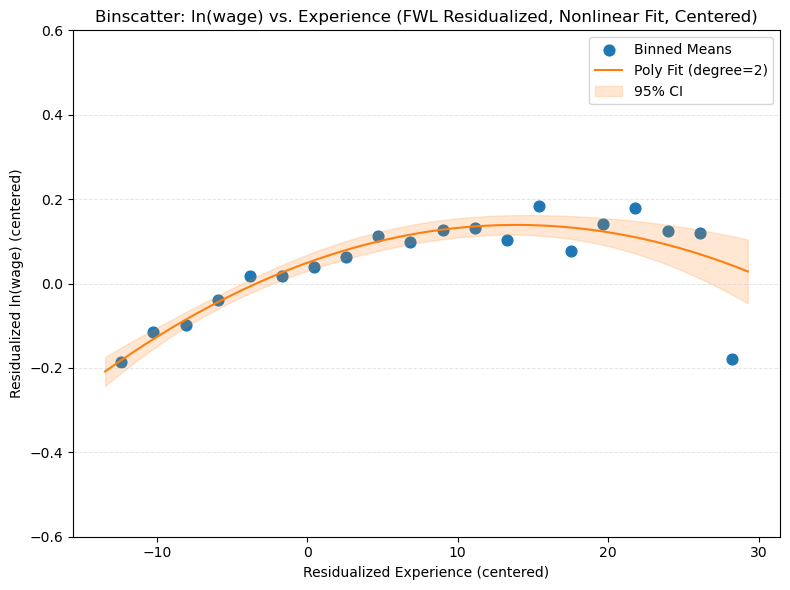

In [107]:
import numpy as np
import seaborn as sns
from scipy.stats import binned_statistic
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from statsmodels.stats.outliers_influence import summary_table

import matplotlib.pyplot as plt
import statsmodels.api as sm

# 只用 wage < 100 的样本
df_plot = df_wage_less_100.copy()

# 1. FWL（Frisch-Waugh-Lovell）残差化处理
# 控制变量：edu_group, region, sex
fwl_controls = ['edu_group', 'region', 'sex']
# 对 ln(wage) 残差化
y = df_plot['lwage']
X_controls = pd.get_dummies(df_plot[fwl_controls], drop_first=True)
X_controls = sm.add_constant(X_controls)
X_controls = X_controls.astype(float)
ols_y = sm.OLS(y, X_controls).fit()
y_resid = ols_y.resid

# 对 exp1 残差化
x = df_plot['exp1']
ols_x = sm.OLS(x, X_controls).fit()
x_resid = ols_x.resid

# 均值中心化
x_resid_centered = x_resid - x_resid.mean()
y_resid_centered = y_resid - y_resid.mean()

# 2. 分箱散点
n_bins = 20
bin_means, bin_edges, binnumber = binned_statistic(
    x_resid_centered, y_resid_centered, statistic='mean', bins=n_bins
)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# 3. 多项式阶数选择（交叉验证，最大到5阶）
X_poly = x_resid_centered.values.reshape(-1, 1)
degrees = range(1, 6)
cv_scores = []
for d in degrees:
    poly = PolynomialFeatures(degree=d)
    X_poly_d = poly.fit_transform(X_poly)
    model = LinearRegression()
    score = cross_val_score(model, 
                            X_poly_d, y_resid_centered, 
                            cv=5, 
                            scoring='neg_mean_squared_error').mean()
    cv_scores.append(score)
best_degree = degrees[np.argmax(cv_scores)]

# 4. 用最优阶数拟合
poly = PolynomialFeatures(degree=best_degree)
X_poly_best = poly.fit_transform(X_poly)
model = LinearRegression().fit(X_poly_best, y_resid_centered)
y_pred = model.predict(X_poly_best)

# 5. 置信区间
X_poly_sm = sm.add_constant(X_poly_best)
ols = sm.OLS(y_resid_centered, X_poly_sm).fit()
st, data, ss2 = summary_table(ols, alpha=0.05)
ci_low, ci_upp = data[:, 4], data[:, 5]

# 6. 绘图
plt.figure(figsize=(8, 6))
plt.scatter(bin_centers, bin_means, color='#1f77b4', 
            s=60, label='Binned Means')
order = np.argsort(X_poly[:, 0])
plt.plot(X_poly[order, 0], y_pred[order], 
         color='#ff7f0e', 
         label=f'Poly Fit (degree={best_degree})')
plt.fill_between(X_poly[order, 0], 
                 ci_low[order], ci_upp[order], 
                 color='#ff7f0e', 
                 alpha=0.18, label='95% CI')
plt.xlabel('Residualized Experience (centered)')
plt.ylabel('Residualized ln(wage) (centered)')
plt.title('Binscatter: ln(wage) vs. Experience (FWL Residualized, Nonlinear Fit, Centered)')
plt.grid(axis='y', color='lightgray', 
         linestyle='--', linewidth=0.7, alpha=0.6)
plt.yticks(np.arange(-0.6, 0.8, 0.2))
plt.tight_layout()
plt.legend()
plt.show()

## 小结


本章介绍了分仓散点图的基本原理与绘制方法，并结合工资决定因素的例子，演示了其在 Python 中的实际应用。

事实上，分仓散点图不仅是描述变量关系的直观工具，更在应用经济学和社会科学实证研究中具有重要意义。

首先，分仓散点图可作为多元回归结果的可视化手段。我们可以利用 Frisch-Waugh-Lovell（FWL）定理，在控制协变量影响的前提下，直观呈现核心自变量与因变量之间的净关系，这对于理解回归系数背后的经济含义和展示部分效应尤为有用。

其次，分仓散点图还是模型设定的重要工具。通过观察分仓均值的变化趋势，我们可以初步判断变量之间的非线性关系或结构性断点，为进一步采用多项式回归、分段回归等方法提供依据。

再次，在数据分析和预处理阶段，分仓散点图有助于快速发现异常值、极端点以及样本结构变化，从而提高数据分析的准确性和稳健性。

此外，该方法还常用于断点回归设计（RDD）、政策评估、因果推断等前沿实证领域，是展示数据特征和检验研究假设的有力工具。

总体来看，分仓散点图作为连接理论分析、数据探索与实证模型设定的桥梁，已经成为现代数据分析和应用计量经济学研究中不可或缺的基础工具。


## 参考文献

* Cattaneo, M. D., Jansson, M., & Ma, X. (2022). binsreg: Estimating and validating binscatter estimators. The Stata Journal, 22(1), 65–99. [Link](https://doi.org/10.1177/1536867X221082097), [PDF](http://sci-hub.ren/10.1177/1536867X221082097), [Google](https://scholar.google.com/scholar?q=binsreg).
- Cattaneo, M. D., Crump, R. K., Farrell, M. H., & Feng, Y. (2024). On Binscatter. American Economic Review, 114(5), 1488--1514. [Link](https://doi.org/10.1257/aer.20221576) (rep), [PDF](https://nppackages.github.io/references/Cattaneo-Crump-Farrell-Feng_2024_AER.pdf), [Appendix](https://www.aeaweb.org/doi/10.1257/aer.20221576.appx), [Google](https://scholar.google.com/scholar?q=On%20Binscatter), [\-Replication-](https://www.openicpsr.org/openicpsr/project/195103/version/V1/view).
- Frisch, R., & Waugh, F. V. (1933). Partial Time Regressions as Compared with Individual Trends. Econometrica, 1(4), 387–401. [Link](https://doi.org/10.2307/1907330), [PDF](http://sci-hub.ren/10.2307/1907330), [Google](https://scholar.google.com/scholar?q=Partial+Time+Regressions+as+Compared+with+Individual+Trends).
- Lovell, M. C. (1963). Seasonal Adjustment of Economic Time Series and Multiple Regression Analysis. Journal of the American Statistical Association, 58(304), 993–1010. [Link](https://doi.org/10.1080/01621459.1963.10480673), [PDF](http://sci-hub.ren/10.1080/01621459.1963.10480673), [Google](https://scholar.google.com/scholar?q=Seasonal+Adjustment+of+Economic+Time+Series+and+Multiple+Regression+Analysis).
- Stepner M. Binscatter: Binned scatterplots in stata[J]. StataConference, 2014. [-PDF-](https://michaelstepner.com/binscatter/binscatter-StataConference2014.pdf)
- 朱志英, 2022, [Stata：分仓散点图应用-binscatter](https://www.lianxh.cn/details/1139.html), 连享会 No.1139.
- 钟声, 2022, [Stata：分仓散点图绘制-binscatter-binscatter2](https://www.lianxh.cn/details/870.html), 连享会 No.870.

